# Parallel SAC with MLP

We will try combinations of:
- exchanging 1 bit vs 1 float
- adding or not the neighbor term to the reward .

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You can skip training and instead load the last trained policy by changing the flag below.

In [15]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

In [16]:
from navground.learning import DefaultObservationConfig

from navground.learning.parallel_env import make_vec_from_penv
from navground.learning.config.control_action_with_comm import ControlActionWithCommConfig
from stable_baselines3.common.vec_env import VecMonitor
from navground.learning.examples.pad import get_env, comm, marker, PadReward

comm_size = 1
action = ControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                     fix_orientation=True, comm_size=comm_size)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)

## Floating-point message, without reward sharing

In [17]:
name = "DistributedCommFloatWithoutRewardSharing"
sensors = [comm(size=comm_size, binarize=False), marker()]
train_env = get_env(action=action, observation=observation, 
                    sensors=sensors, start_in_opposite_sides=False, 
                    reward=PadReward(neighbor_weight=0))
train_venv = VecMonitor(make_vec_from_penv(train_env, num_envs=4))
test_env = get_env(action=action, observation=observation, 
                   sensors=sensors, start_in_opposite_sides=True)
test_venv = VecMonitor(make_vec_from_penv(test_env, num_envs=4))

In [18]:
test_venv.observation_space, train_venv.observation_space

(Dict('neighbor/comm': Box(-1.0, 1.0, (1,), float32), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32)),
 Dict('neighbor/comm': Box(-1.0, 1.0, (1,), float32), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32)))

In [19]:
%%skip_if $training

import pathlib, os
from stable_baselines3 import SAC

log_float = max(pathlib.Path(f'logs/{name}/SAC').glob('*'), key=os.path.getmtime)

In [ ]:
%%run_if $training

from stable_baselines3 import SAC
from datetime import datetime as dt
from stable_baselines3.common.logger import configure
from navground.learning.utils.sb3 import callbacks
from navground.learning.scenarios.pad import render_kwargs

kwargs = render_kwargs(comm=True, low=-1, high=1, binarize=False,
                       color_low=(1, 0, 0), color_high=(0, 1, 0))
model_float = SAC("MultiInputPolicy", train_venv, verbose=0, use_sde=False)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log_float = f"logs/{name}/SAC/{stamp}"
model_float.set_logger(configure(log_float, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_venv, best_model_save_path=log_float, 
                eval_freq=500, export_to_onnx=True, **kwargs)
log_float

'logs/DistributedCommFloatWithoutRewardSharing/SAC/20250521_140207'

In [21]:
%%run_if $training

model_float.learn(total_timesteps=300_000,reset_num_timesteps=False, log_interval=10, callback=cbs)
model_float.num_timesteps

  0%|          | 0/300000 [00:00<?, ?it/s]

300000

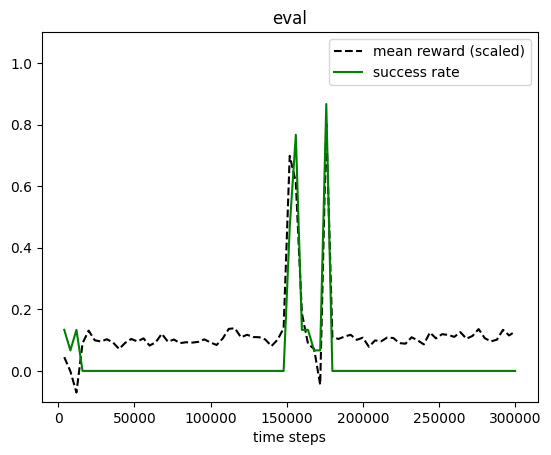

In [22]:
from navground.learning.utils.sb3 import plot_eval_logs

plot_eval_logs(log_float, reward_low=-200, reward_high=0, success=True, figsize=(8, 3))

In [23]:
from stable_baselines3.common.evaluation import evaluate_policy

best_model_float = SAC.load(f'{log_float}/best_model')
evaluate_policy(best_model_float.policy, test_venv, n_eval_episodes=100)

(-26.62414, 40.722)

In [27]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=best_model_float.policy, factor=4, seed=1, **kwargs)

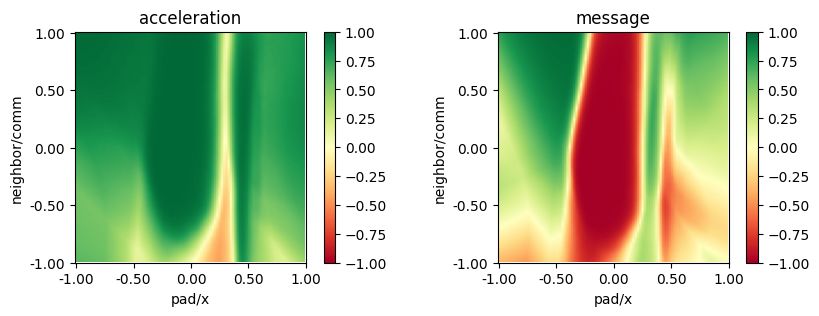

In [28]:
from navground.learning.utils.plot import plot_policy

plot_policy(best_model_float.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)

Let us record communication during a run and plot it

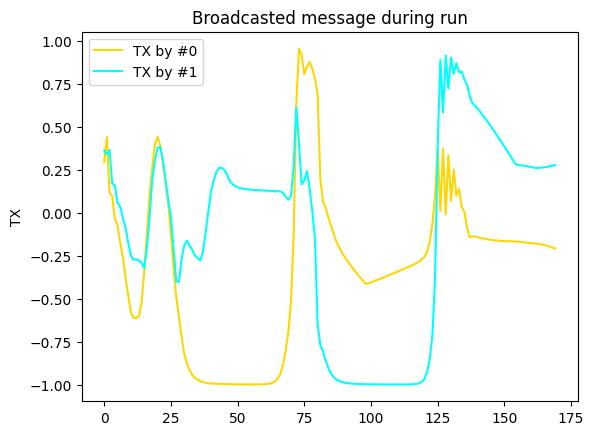

In [31]:
from navground.learning.evaluation.experiment import make_experiment_with_env
from navground.learning.probes.comm import CommProbe
from matplotlib import pyplot as plt
import numpy as np

exp = make_experiment_with_env(test_env, policy=best_model_float.policy)
exp.add_record_probe('tx', CommProbe)
run = exp.run_once(seed=1)
plt.figure(figsize=(8, 3))
for i, color in enumerate(('gold', 'cyan')):
    plt.plot(np.asarray(run.records['tx'])[:, i, 0], color=color, label=f"TX by #{i}")
plt.legend()
plt.ylabel("TX")
plt.title("Broadcasted message during run");

...

## Floating-point message, with reward sharing

In [33]:
name = "DistributedCommFloatWithRewardSharing"
train_env = get_env(action=action, observation=observation, 
                    sensors=sensors, start_in_opposite_sides=False, 
                    reward=PadReward(neighbor_weight=0.5))
train_venv = VecMonitor(make_vec_from_penv(train_env, num_envs=4))

In [34]:
%%skip_if $training

log_float_sharing = max(pathlib.Path(f'logs/{name}/SAC').glob('*'), key=os.path.getmtime)

In [35]:
%%run_if $training

model_float_sharing = SAC("MultiInputPolicy", train_venv, verbose=0, use_sde=False)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log_float_sharing = f"logs/{name}/SAC/{stamp}"
model_float_sharing.set_logger(configure(log_float_sharing, ["csv", "tensorboard"]))
cbs = callbacks(venv=test_venv, best_model_save_path=log_float_sharing, 
                eval_freq=500, export_to_onnx=True, **kwargs)
log_float_sharing

'logs/DistributedCommFloatWithRewardSharing/SAC/20250521_141550'

In [36]:
%%run_if $training

model_float_sharing.learn(total_timesteps=300_000,reset_num_timesteps=False, 
                          log_interval=10, callback=cbs)
model_float_sharing.num_timesteps

  0%|          | 0/300000 [00:00<?, ?it/s]

300000

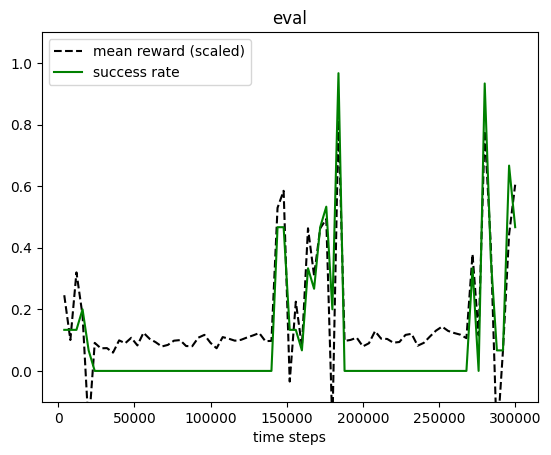

In [37]:
plot_eval_logs(log_float_sharing, reward_low=-200, reward_high=0, 
               success=True, figsize=(8, 3))

In [38]:
best_model_float_sharing = SAC.load(f'{log_float_sharing}/best_model')
evaluate_policy(best_model_float_sharing.policy, test_venv, n_eval_episodes=100)

(-36.095158, 25.466118)

In [39]:
display_episode_video(test_env, policy=best_model_float_sharing.policy, factor=4, seed=1, **kwargs)

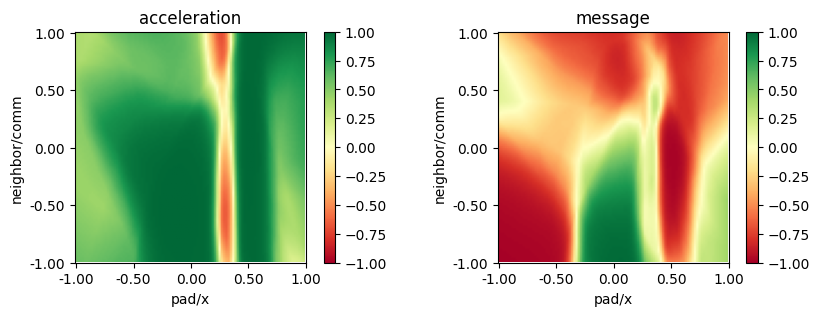

In [40]:
plot_policy(best_model_float_sharing.policy, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)

## Binary message, with reward sharing

In [68]:
name = "DistributedCommBinaryWithRewardSharing"
sensors_bin = [comm(size=comm_size, binarize=True), marker()]
train_env_bin = get_env(action=action, observation=observation, 
                        sensors=sensors_bin, start_in_opposite_sides=False, 
                        reward=PadReward(neighbor_weight=0.5))
train_venv_bin = VecMonitor(make_vec_from_penv(train_env_bin, num_envs=4))
test_env_bin = get_env(action=action, observation=observation, 
                       sensors=sensors_bin, start_in_opposite_sides=True)
test_venv_bin = VecMonitor(make_vec_from_penv(test_env_bin, num_envs=4))

In [69]:
test_venv_bin.observation_space

Dict('neighbor/comm': Box(0, 1, (1,), int8), 'pad/x': Box(-1.0, 1.0, (1,), float32), 'ego_velocity': Box(-0.14, 0.14, (1,), float32))

In [70]:
%%skip_if $training

log_bin_sharing = max(pathlib.Path(f'logs/{name}/SAC').glob('*'), key=os.path.getmtime)

In [71]:
%%run_if $training

model_bin_sharing = SAC("MultiInputPolicy", train_venv_bin, verbose=0, use_sde=False)
stamp = dt.now().strftime("%Y%m%d_%H%M%S")
log_bin_sharing = f"logs/{name}/SAC/{stamp}"
model_bin_sharing.set_logger(configure(log_bin_sharing, ["csv", "tensorboard"]))
kwargs_bin = render_kwargs(comm=True, low=0, high=1,
                           color_low=(1, 0, 0), color_high=(0, 1, 0))
cbs = callbacks(venv=test_venv_bin, best_model_save_path=log_bin_sharing, 
                eval_freq=500, export_to_onnx=True, **kwargs_bin)
log_bin_sharing

'logs/DistributedCommBinaryWithRewardSharing/SAC/20250521_144105'

In [72]:
%%run_if $training

model_bin_sharing.learn(total_timesteps=100_000, reset_num_timesteps=False, 
                        log_interval=10, callback=cbs)
model_bin_sharing.num_timesteps

  0%|          | 0/100000 [00:00<?, ?it/s]

100000

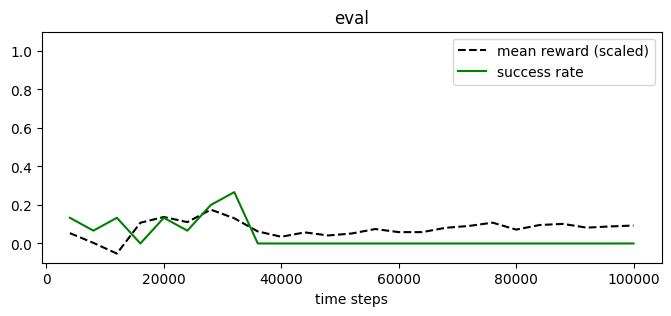

In [73]:
plot_eval_logs(log_bin_sharing, reward_low=-200, reward_high=0, 
               success=True, figsize=(8, 3))

In [77]:
best_model_bin_sharing = SAC.load(f'{log_bin_sharing}/best_model')
evaluate_policy(best_model_bin_sharing.policy, test_venv_bin, n_eval_episodes=100)

(-209.73132, 122.59714)

In [81]:
display_episode_video(test_env_bin, policy=best_model_bin_sharing.policy, factor=4, 
                      seed=1, **kwargs_bin)

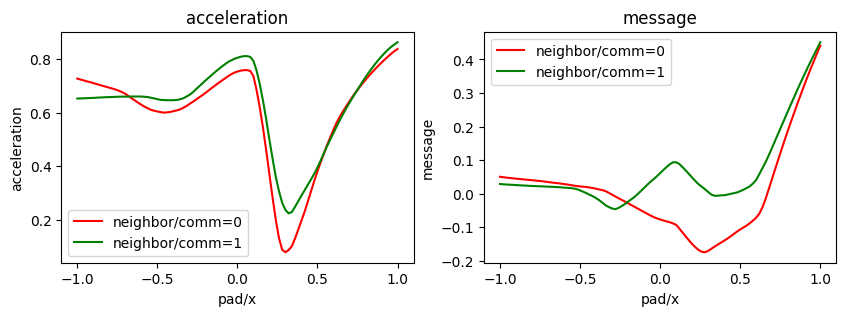

In [82]:
plot_policy(best_model_bin_sharing.policy, 
            variable={'pad/x': (-1, 1)},
            fix={'ego_velocity': 0.07,  'neighbor/comm': [0, 1]},
            colors=['red', 'green'],
            actions={0: 'acceleration', 1: 'message'}, 
            width=5, height=3)

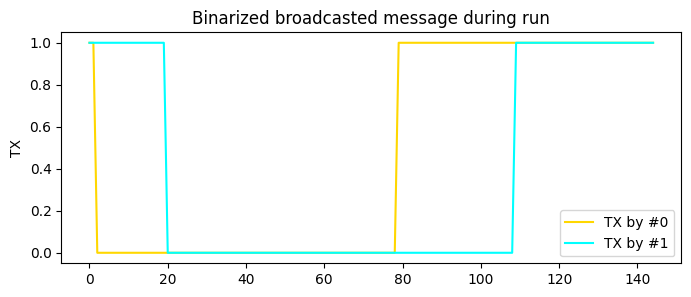

In [83]:
exp = make_experiment_with_env(test_env, policy=best_model_bin_sharing.policy)
exp.add_record_probe('tx', CommProbe)
run = exp.run_once(seed=1)
plt.figure(figsize=(8, 3))
for i, color in enumerate(('gold', 'cyan')):
    tx = np.asarray(run.records['tx'])[:, i, 0]
    rx = (tx > 0).astype(int)
    plt.plot(rx, color=color, label=f"TX by #{i}")
plt.legend()
plt.ylabel("TX")
plt.title("Binarized broadcasted message during run");

## Summary

From this (very) limited experiment, we may like to infer some general observations:

- without reward sharing, it does not learn to coordinate.
- with reward sharing, it learns but it is *very* unstable (which is not surprising)
- the best models learnt with reward sharing makes sense: the agent signals its precense near the pad
- there no significant advantage in sharing a float or a bit (at least with this configuration, 
  where binarization happens during observation, but actions are continuous)